# Section 4: Numerical experiments
Read in output of test models on $\mathfrak n \widehat R$ and generate figures and tables for the paper.

In [1]:
import numpy as np
from matplotlib.pyplot import *
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

# Use this to silence check type warning messages.
import logging
logging.disable(logging.WARNING)

import jax
from jax import random
from jax import numpy as jnp

# import tfp models and datasets
from inference_gym import using_jax as gym

from fun_mc import using_jax as fun_mcmc

from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import unnest
import tensorflow_probability as _tfp
tfp = _tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

tfp_np = _tfp.substrates.numpy
tfd_np = tfp_np.distributions


# import arviz as az
from tensorflow_probability.python.internal.unnest import get_innermost  

2024-05-23 10:51:43.777111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Directory to save results (adjust to your setting!)
deliv_dir = "/mnt/home/cmargossian/Code/nested-rhat/deliv/"
data_dir = "/mnt/home/cmargossian/Code/nested-rhat/data/"
fig_dir = "/mnt/home/cmargossian/Code/nested-rhat/figures/"

with open("utility.py") as f: exec(f.read())

In [3]:
# Allows figures to rend latex

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
# rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{amsfonts}']

#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{amsfonts}']
# !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [4]:
# rcParams.update(rcParamsDefault)  # check if this fixed latex font

## Utility functions

In [5]:
def read_results (model_name, K, M, N):
    root_address = deliv_dir + model_name + "_K" + str(K) + "_M" +\
                   str(M) + "_N" + str(N)
    return np.load(root_address + "_nrhat.npy"),\
           np.load(root_address + "_squared_error.npy")

def read_results_all (model_names, K, M, N):
    num_warmup_window = 380
    nRhat_exp = [] # np.empty((len(model_names), num_warmup_window))
    err_exp = [] # np.empty((len(model_names), num_warmup_window))
    for i in range(len(model_names)):
        nRhat_target, err_target = read_results(model_names[i], K, M, N)
        nRhat_exp.append(nRhat_target)
        err_exp.append(err_target)
    return nRhat_exp, err_exp

def quadrant_counts (nRhat_array, err_array, nRhat_upper, chi_squared_uq):
  # For a given threshold, return the number of points that exceed an
  # expected threshold at stationarity, as specified by chi_squared_uq,
  # under the assumption of stationarity (per the CLT).
  num_conv = sum(nRhat_array < nRhat_upper)
  num_nonconv = sum(nRhat_array > nRhat_upper)
  num_fp = sum((nRhat_array < nRhat_upper) & (err_array > chi_squared_uq))
  num_fn = sum((nRhat_array > nRhat_upper) & (err_array < chi_squared_uq))

  return np.array([num_fp / num_conv,
                   1 - num_fp / num_conv,
                   num_fn / num_nonconv,
                   1 - num_fn / num_nonconv,
                   num_conv])

def viol_counts (model_names, threshold_list, nRhat_exp, err_exp,
                 nRhat_upper, chi_squared_uq, min_num_obs = 100):
    viol_exp = np.empty((len(model_names), len(threshold_list)))
    count_exp = np.empty((len(model_names), len(threshold_list)))
    index_exp = np.empty((len(model_names)))
    for j in range(len(model_names)):
        for i in range(len(threshold_list)):
            quad_result = quadrant_counts(nRhat_exp[j], err_exp[j],
                                          threshold_list[i], chi_uq)
            viol_exp[j,i] = quad_result[0]
            count_exp[j,i] = quad_result[4]
        
        index_exp[j] = next(x[0] for x in enumerate(count_exp[j]) if x[1] > min_num_obs)
    
    return viol_exp, count_exp, index_exp

# for i in threshold_list:
#   quad_result = quadrant_counts(nRhat_rosenbrock, err_rosenbrock, i, chi_uq)
#   viol_rosenbrock.append(quad_result[0])
#   count_rosenbrock.append(quad_result[4])


def err_eps_compute (err_exp, eps):
    err_eps = []
    for i in range(len(err_exp)):
        err_eps.append(err_exp[i][nRhat_exp[i] <= 1 + eps])
    return err_eps


In [6]:
#     nRhat_rosenbrock, err_rosenbrock = read_results("rosenbrock", K, M, N)
#     nRhat_german, err_german = read_results("german", K, M, N)
#     nRhat_schools, err_schools = read_results("schools", K, M, N)
#     nRhat_pk, err_pk = read_results("pk", K, M, N)
#     nRhat_itr, err_itr = read_results("itr", K, M, N)
#     nRhat_bimodal, err_bimodal = read_results("bimodal", K, M, N)

### Generate plots

In [41]:
# Hyperparameter for the experiment
K = 16  # options: 2, 8, 16, 64, 256, 1024 
num_chains = 2048
M = num_chains // K
N = 1
nRhat_upper = 1.01  # Define nRhat_upper (standard threshold)
eps = nRhat_upper - 1

# quantiles for chi squared with df = 1
chi_up = 3.841459 # 95th quantile for chi squared with df = 1
chi_lo = 0.00393214  # 05th quantile for chi squared with df = 1
chi_uq = chi_up / num_chains

tau = 1e-4
nRhat_lower = np.sqrt(1 + 1 / M + tau)
eps_lower = nRhat_lower - 1

naive_super_chains = False

if naive_super_chains:
    model_names = ["rosenbrock_naive", "german_naive", "schools_naive", "pk_naive",
                   "itr_naive", "bimodal_naive"]
else:
    model_names = ["rosenbrock", "german", "schools", "pk", "itr", "bimodal"]

model_labels = ["Rosenbrock", "German Credit", "Eight Schools", "Pharmacokinetics",
                "Item Response", "Bimodal"]



In [42]:
nRhat_exp, err_exp = read_results_all(model_names, K, M, N)

### Violation plots
Plot the fraction of time the squared error exceeds the error we would expect if the Markov chains were stationary, against $\mathfrak n \widehat R$. For the bimodal case, $\mathfrak n \widehat R$ stays large, so we do not plot for this example the behavior of the error as $\mathfrak n \widehat R$ approaches 1.

In [43]:
threshold_list = np.arange(1.0, 1.3, 0.001)
min_num_obs = 100  # min obs to evaluate fraction above 95th quantile


In [44]:
viol_exp, count_exp, index_exp = viol_counts(model_names[:5], threshold_list,
                                             nRhat_exp, err_exp, nRhat_upper,
                                             chi_uq, min_num_obs)

/tmp/ipykernel_1190316/33088146.py:26: RuntimeWarning: invalid value encountered in scalar divide
  return np.array([num_fp / num_conv,
/tmp/ipykernel_1190316/33088146.py:27: RuntimeWarning: invalid value encountered in scalar divide
  1 - num_fp / num_conv,
/tmp/ipykernel_1190316/33088146.py:28: RuntimeWarning: invalid value encountered in scalar divide
  num_fn / num_nonconv,
/tmp/ipykernel_1190316/33088146.py:29: RuntimeWarning: invalid value encountered in scalar divide
  1 - num_fn / num_nonconv,


In [45]:
epsilon = threshold_list
epsilon[:] = [number - 1.0 for number in threshold_list]

# For a given threshold, compute a histogram of the squared error.
eps = 1 / M + tau
err_eps = err_eps_compute(err_exp, eps)

# Squared error expected for scaled stationary Markov chains
err_chi2 = np.random.chisquare(df = 1, size = (100000, )) / num_chains

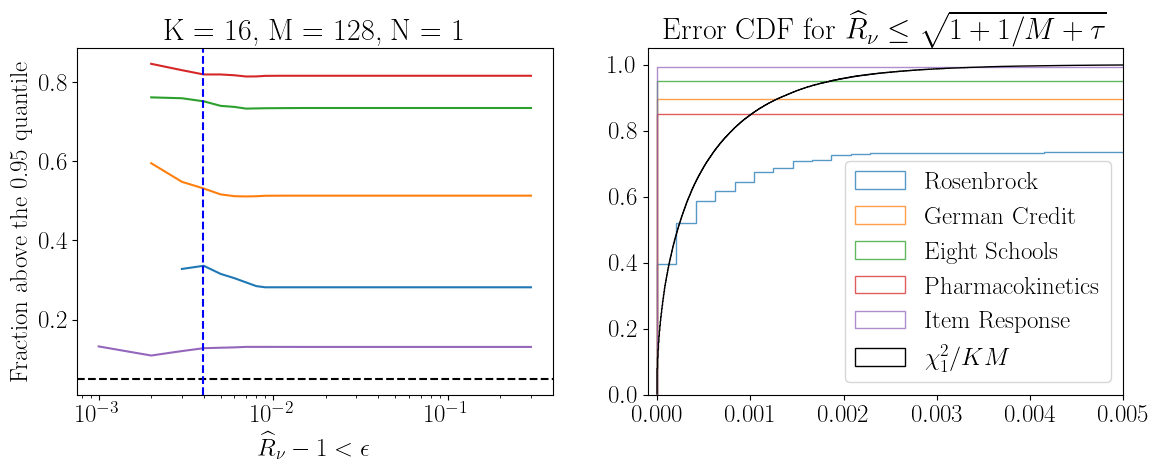

In [46]:
fig, ax = subplots(1, 2, figsize=(13.5, 4.5))

ax[0].set_xscale('log')
for i in range(len(model_names) - 1):  # exclude bimodal example
    ax[0].plot(epsilon[int(index_exp[i]):], viol_exp[i][int(index_exp[i]):],
               label = model_labels[i])

ax[0].axhline(y = 0.05, color = 'black', linestyle = '--')
ax[0].axvline(x = eps_lower, color = 'blue', linestyle = '--')
ax[0].set(ylabel = "Fraction above the 0.95 quantile")
ax[0].set(xlabel = "$\widehat R_{\\nu} - 1 < \epsilon$")
ax[0].set(title = "K = " + str(K) + ", M = " + str(M) + ", N = " + str(N))

for i in range(len(model_names) - 1):
    ax[1].hist(err_eps[i], histtype="step", cumulative=True, density=True, bins=200,
           label=model_labels[i], alpha = 0.75)

ax[1].hist(err_chi2, histtype = "step", cumulative = True, density = True, bins = 2000,
           label = '$\chi^2_1 / KM$', color = 'black')
ax[1].legend(loc = "lower right")
ax[1].set_xlim(left = -0.0001, right = 0.005)
ax[1].set(title = "Error CDF for $\widehat R_{\\nu} \le \sqrt{1 + 1 / M + \\tau}$")

filename = "fraction_" + "K" + str(K) + "_M" + str(M) + "_N" + str(N) + ".pdf"
if naive_super_chains:
    filename = "naive_" + filename
savefig(fig_dir + filename, bbox_inches='tight')

# Note: the bimodal example does not render on this plot because nR

In [47]:
import matplotlib.ticker as mticker

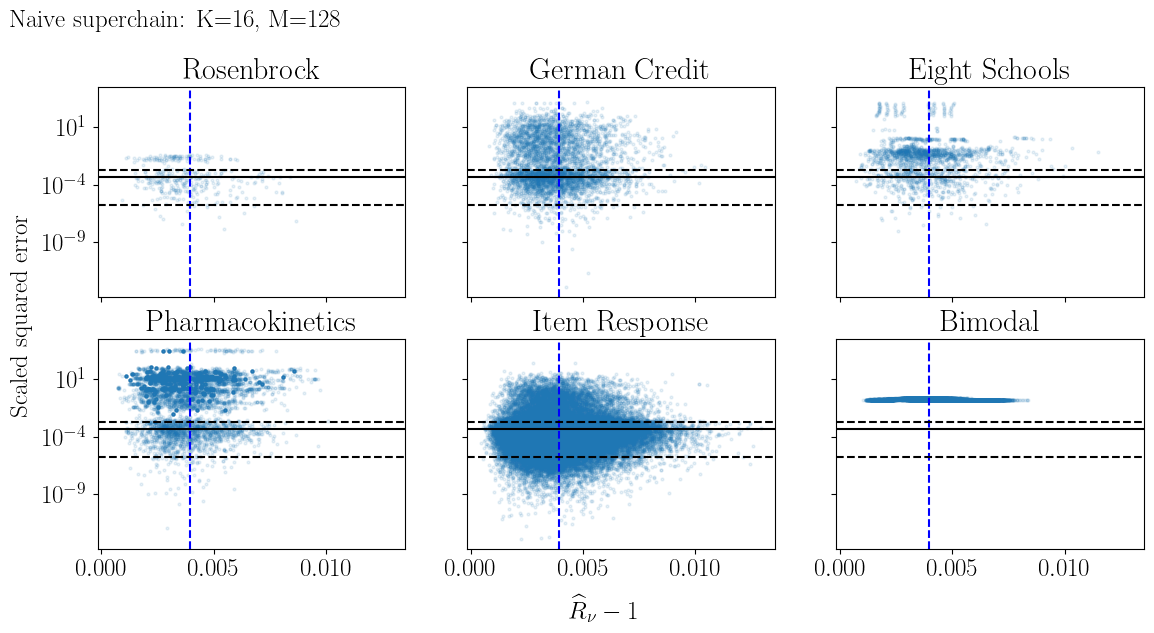

In [48]:
fig, ax = subplots(2, 3, sharey = True, sharex = True, figsize=(13.5, 6))

s_point = 4  # size of points
for i in range(len(model_names)):
    col_index = i - (i // 3) * 3
    row_index = i // 3
    alpha = 0.1
    if (model_names[i] == "itr"): alpha = 0.01
    ax[row_index, col_index].scatter(nRhat_exp[i] - 1, err_exp[i], alpha = alpha, s = s_point)
    ax[row_index, col_index].set(title = model_labels[i])
    ax[row_index, col_index].set_rasterized(True)  # makes plot smaller and load faster


for a in ax.flat:
    if False: a.set(ylabel='Scaled squared error')
    a.set_yscale('log')
    if not naive_super_chains:
        a.set_xscale('log')
    # a.axvline(x = eps, linestyle = '--', color = 'orange')
    a.axvline(x = eps_lower, linestyle = '--', color = 'blue')
    a.axhline(y = 1 / num_chains, color = 'black')
    a.axhline(y = chi_up / num_chains, color = 'black', linestyle = '--')
    a.axhline(y = chi_lo / num_chains, color = 'black', linestyle = '--')


# if not naive_super_chains:
# xlim(left = 1e-2)
if naive_super_chains:
    plot_title = "Naive superchain: K=" + str(K) + ", M=" + str(M)
else:
    plot_title = "Constrained superchain: K=" + str(K) + ", M=" + str(M)

if True:
    fig.text(0.5, 0.01, "$\widehat R_{\\nu} - 1$", ha='center', va='center')
    fig.text(0.06, 0.5, "Scaled squared error", rotation=90, va='center')
fig.text(0.06, 0.98, plot_title)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()
    # if naive_super_chains:
        # a.ticklabel_format(axis='x', style='plain', useOffset=0.01)
        # a.xaxis.set_minor_formatter(mticker.ScalarFormatter())
        # a.tick_params(axis="x", rotation=45, labelsize=10)


# show()  
filename = "scatter_" + "K" + str(K) + "_M" + str(M) + "_N" + str(N) + ".pdf"
if naive_super_chains:
    filename = "naive_" + filename
savefig(fig_dir + filename, bbox_inches='tight')


### Plots comparing K

In [24]:
K_list = np.array([2, 8, 16, 64, 256, 1024])

In [25]:
print("num_chains:", num_chains)

num_chains: 2048


In [26]:
nRhat_exp_K = []
err_exp_K = []
viol_exp_K = []
count_exp_K = []
index_exp_K = []

threshold_list = np.arange(1.0, 1.3, 0.0005)
min_num_obs = 100

for k in range(len(K_list)):
    K = K_list[k]
    M = num_chains // K
    nRhat_exp, err_exp = read_results_all(model_names, K_list[k], M, N)
    nRhat_exp_K.append(nRhat_exp)
    err_exp_K.append(err_exp)
    
    viol_exp, count_exp, index_exp = viol_counts(model_names[:5], threshold_list,
                                             nRhat_exp, err_exp, nRhat_upper,
                                             chi_uq, min_num_obs)
    viol_exp_K.append(viol_exp)
    count_exp_K.append(count_exp)
    index_exp_K.append(index_exp)


/tmp/ipykernel_1190316/33088146.py:26: RuntimeWarning: invalid value encountered in scalar divide
  return np.array([num_fp / num_conv,
/tmp/ipykernel_1190316/33088146.py:27: RuntimeWarning: invalid value encountered in scalar divide
  1 - num_fp / num_conv,


In [27]:
threshold_list = np.arange(1.0, 1.3, 0.0005)
epsilon = threshold_list
epsilon[:] = [number - 1.0 for number in threshold_list]

# For a given threshold, compute a histogram of the squared error.
eps = 1 / M + tau  # ToDo: Fix this!!
err_eps = err_eps_compute(err_exp, eps)

# Squared error expected for scaled stationary Markov chains
err_chi2 = np.random.chisquare(df = 1, size = (100000, )) / num_chains

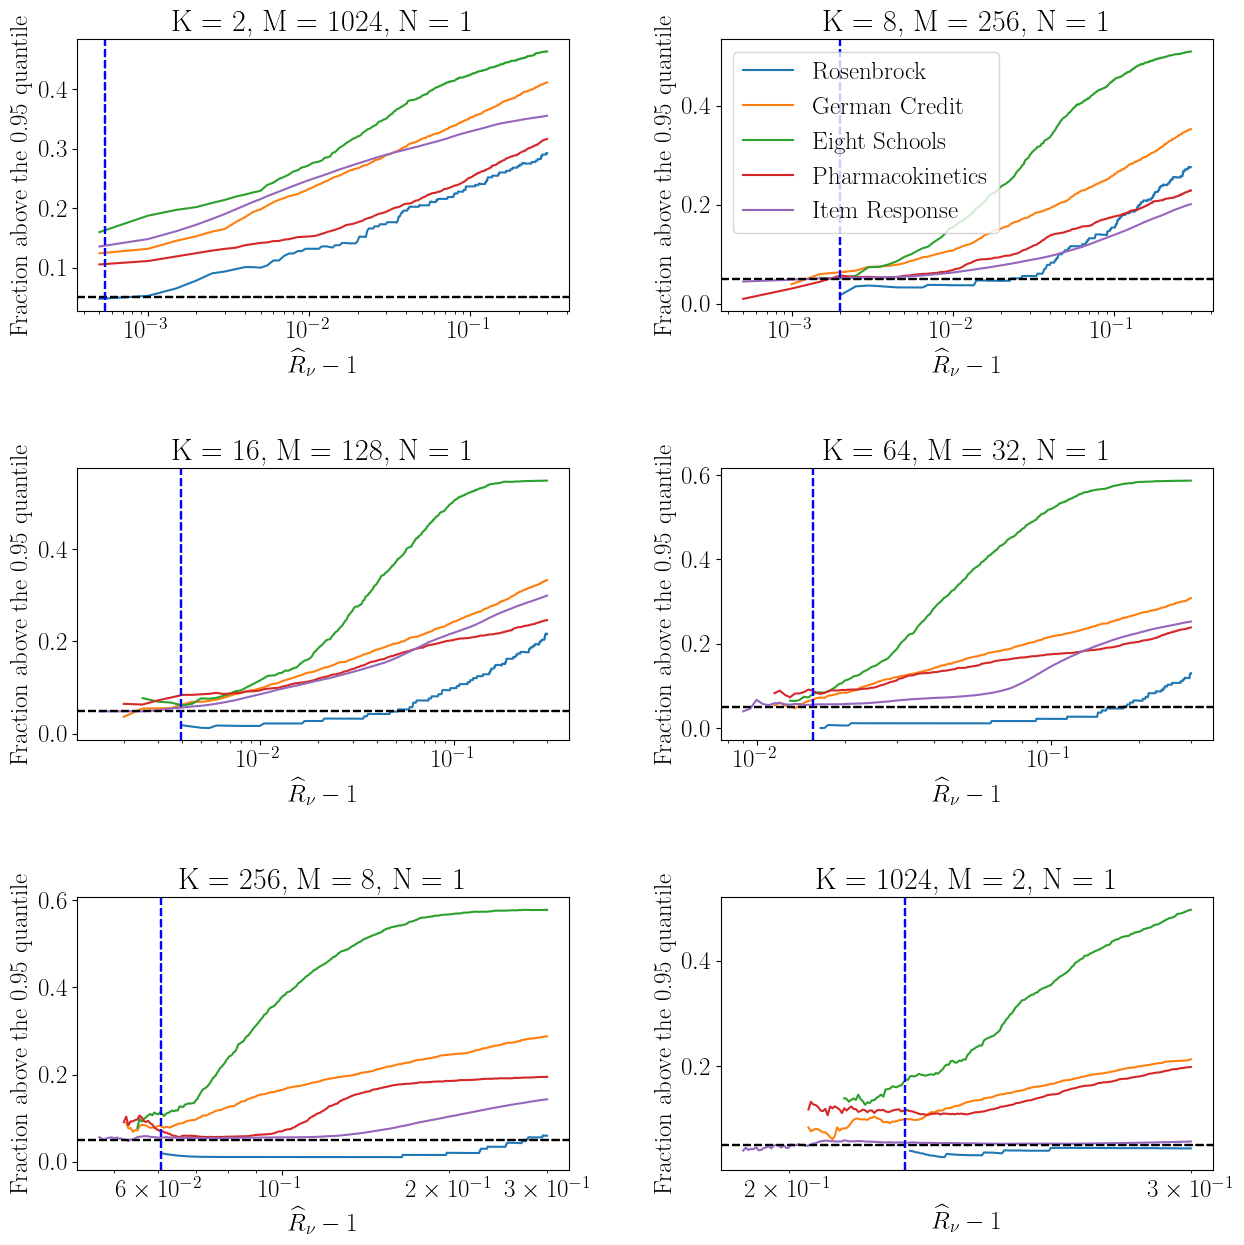

In [29]:
fig, ax = subplots(3, 2, figsize=(13.5, 13.5))

for k in range(len(K_list)):
    col_index = k - (k // 2) * 2
    row_index = k // 2
    
    for i in range(len(model_names) - 1):  # exclude bimodal example
        ax[row_index, col_index].plot(epsilon[int(index_exp_K[k][i]):],
                                      viol_exp_K[k][i][int(index_exp_K[k][i]):],
                                      label = model_labels[i])

        M = num_chains // K_list[k]
        eps_lower = np.sqrt(1 + 1 / M + tau) - 1
        
        ax[row_index, col_index].set_xscale('log')
        
        ax[row_index, col_index].axhline(y = 0.05, color = 'black', linestyle = '--')
        # ax[row_index, col_index].axvline(x = eps, color = 'orange', linestyle = '--')
        ax[row_index, col_index].axvline(x = eps_lower, color = 'blue', linestyle = '--')
        ax[row_index, col_index].set(ylabel = "Fraction above the 0.95 quantile")
        ax[row_index, col_index].set(xlabel = "$\widehat R_{\\nu} - 1$")
        ax[row_index, col_index].set(title = "K = " + str(K_list[k]) +\
                                     ", M = " + str(M) + ", N = " + str(N))
    if k == 1: ax[row_index, col_index].legend(loc = "best")


fig.tight_layout(pad=2.5)
filename = "frac_all_" + "K" + str(K) + "_M" + str(M) + "_N" + str(N) + ".pdf"
savefig(fig_dir + filename, bbox_inches = 'tight')

### Comparing superchains and naive superchains

In [30]:
K = 16
M = 2048 // K
N = 1

# Can keep the naive runs fixed (partition doesn't impact MSE)
K_naive = 16
M_naive = 2048 // K_naive
N_naive = 1

model_names = ["rosenbrock", "german", "schools", "pk", "itr", "bimodal"]

model_names_naive = ["rosenbrock_naive", "german_naive", "schools_naive", "pk_naive",
                   "itr_naive", "bimodal_naive"]

num_seed = 10

In [31]:
nRhat_exp, err_exp = read_results_all(model_names, K, M, N)
nRhat_exp_naive, err_exp_naive = read_results_all(model_names_naive, K_naive, M_naive, N_naive)

In [32]:
max_warmup = 1000
warmup_window = 100

window_array = np.append(np.repeat(10, 10),
                      np.repeat(warmup_window, max_warmup // warmup_window - 1))

warmup_length = np.repeat(10, len(window_array))
for i in range(len(warmup_length) - 1):
    warmup_length[i + 1] = warmup_length[i] + window_array[i + 1]



In [33]:
model_dim = [2, 25, 10, 45, 501, 100]
num_model = len(model_dim)
n_windows = len(warmup_length)

mse_all = np.empty((num_model, len(warmup_length)))
mse_l = np.empty((num_model, len(warmup_length)))
mse_u = np.empty((num_model, len(warmup_length)))

mse_naive_all = np.empty((num_model, len(warmup_length)))
mse_naive_l = np.empty((num_model, len(warmup_length)))
mse_naive_u = np.empty((num_model, len(warmup_length)))

index_l = 0  # 2
index_u = 9  # 7

for model_index in range(num_model):
    dim = model_dim[model_index]  # For PK
    err_model = err_exp[model_index].reshape(num_seed, n_windows, dim)
    mse = np.mean(err_model, axis=2)
    mse_all[model_index] = np.mean(mse, axis = 0)
    mse_l[model_index] = np.sort(mse, axis = 0)[index_l]
    mse_u[model_index] = np.sort(mse, axis = 0)[index_u]

    err_naive_model = err_exp_naive[model_index].reshape(num_seed, n_windows, dim)
    mse_naive = np.mean(err_naive_model, axis=2)
    mse_naive_all[model_index] = np.mean(mse_naive, axis = 0)
    mse_naive_l[model_index] = np.sort(mse_naive, axis = 0)[index_l]
    mse_naive_u[model_index] = np.sort(mse_naive, axis = 0)[index_u]


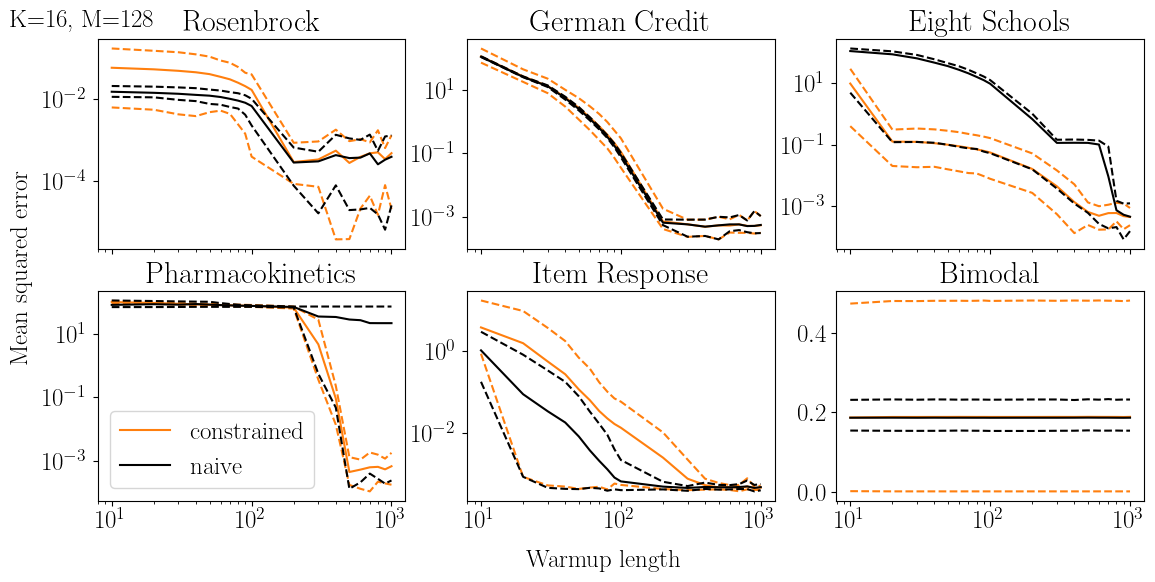

In [34]:
fig, ax = subplots(2, 3, sharey = False, sharex = True, figsize=(13.5, 6))

model_index = 0
for a in ax.flat:
    a.plot(warmup_length, mse_all[model_index], color = "tab:orange", label = "constrained")
    a.plot(warmup_length, mse_u[model_index], '--', color = "tab:orange")
    a.plot(warmup_length, mse_l[model_index], '--', color = "tab:orange")

    a.plot(warmup_length, mse_naive_all[model_index], color = 'black', label = "naive")
    a.plot(warmup_length, mse_naive_u[model_index], '--', color = "black")
    a.plot(warmup_length, mse_naive_l[model_index], '--', color = "black")

    
    a.set(title = model_labels[model_index])
    if not (model_index == 5): 
        a.set_yscale('log')
        a.set_xscale('log')
    model_index += 1


ax[1, 0].legend(loc = "best")

fig.text(0.5, 0.01, "Warmup length", ha='center', va='center')
fig.text(0.06, 0.5, "Mean squared error", rotation=90, va='center')

plot_title = "K=" + str(K) + ", M=" + str(M)
fig.text(0.06, 0.9, plot_title)


filename = "mse_" + "K" + str(K) + "_M" + str(M) + "_N" + str(N) + ".pdf"
savefig(fig_dir + filename, bbox_inches='tight')


In [35]:
model_index = 1
K_all = [2, 8, 16, 64, 256, 1024]

def compute_mse(model_index, K_all=K_all):
    mse_all = np.empty((len(K_all), len(warmup_length)))
    mse_naive = np.empty((len(K_all), len(warmup_length)))

    mse_u = np.empty((len(K_all), len(warmup_length)))
    mse_l = np.empty((len(K_all), len(warmup_length)))

    for k in range(len(K_all)):
        M = 2048 // K_all[k]
        N = 1
        dim = model_dim[model_index]
        _, err_exp = read_results_all(model_names, K_all[k], M, N)
        err_model = err_exp[model_index].reshape(num_seed, n_windows, dim)
        mse = np.mean(err_model, axis=2)
    
        mse_all[k] = np.mean(mse, axis=0)  # mean or median?
        # mse_l[k] = np.sort(mse, axis=0)[index_l]
        # mse_u[k] = np.sort(mse, axis=0)[index_u]

        err_naive_model = err_exp_naive[model_index].reshape(num_seed, n_windows, dim)
        mse_naive = np.mean(err_naive_model, axis=2)
        mse_naive_all[model_index] = np.mean(mse_naive, axis = 0)
    
    return mse_all, mse_naive_all


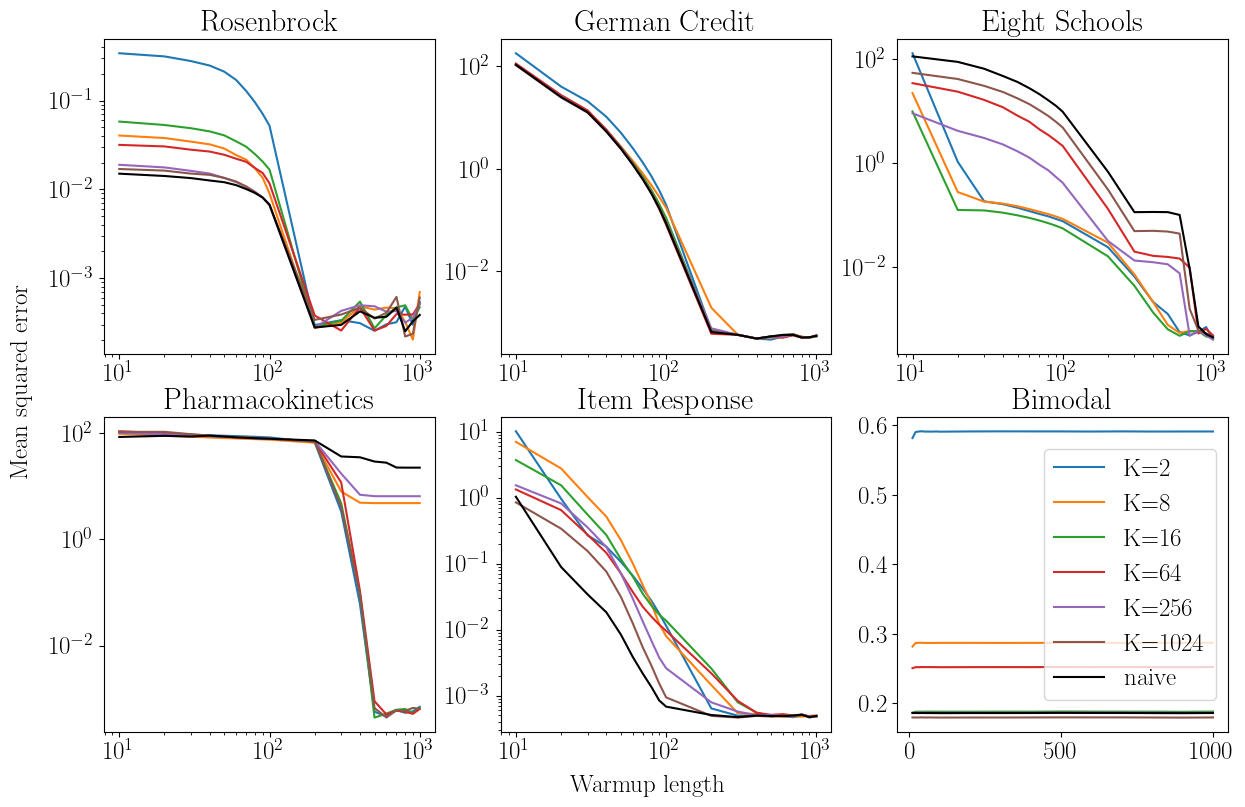

In [36]:
fig, ax = subplots(2, 3, figsize=(14.5, 9))

tab_color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink',
             'gray', 'olive', 'cyan']

model_index = 0
for a in ax.flat:
    mse_all, mse_naive_all = compute_mse(model_index)
    for k in range(len(K_all)):
        a.plot(warmup_length, mse_all[k], label = "K=" + str(K_all[k]),
                color = "tab:" + tab_color[k])
    # ax.plot(warmup_length, mse_l[k], '--', color = "tab:" + tab_color[k], alpha=0.1)
    # ax.plot(warmup_length, mse_u[k], '--', color = "tab:" + tab_color[k], alpha=0.1)

    a.plot(warmup_length, mse_naive_all[model_index], label = "naive", color = 'black')

    if not (model_index == 5):
        a.set_yscale('log')
        a.set_xscale('log')
    a.set(title = model_labels[model_index])
    
    model_index += 1

ax[1,2].legend(loc="right")

fig.text(0.5, 0.05, "Warmup length", ha='center', va='center')
fig.text(0.06, 0.5, "Mean squared error", rotation=90, va='center')

filename = "mse_varyingK_" + ".pdf"
savefig(fig_dir + filename, bbox_inches='tight')

### Adaptive warmup length
Rather than we rerun the experiment with an early stop, we'll retroactively construct the stop. The adaptive warmup length algorithm is conservative and so will work best for problems of moderate dimension.

In [37]:
max_warmup = 1000
warmup_window = 100
window_array = np.append(np.repeat(10, 10),
                      np.repeat(warmup_window, max_warmup // warmup_window - 1))

In [38]:
M = 128
tau = 1e-4
nRhat_tol = np.sqrt(1 + 1 / M + tau)

In [39]:
num_param = 10
data_index = 0
for i in range(len(window_array)):
    nRhat_max = np.min(nRhat_exp_K[3][2][(data_index + 0):(data_index + num_param)])
    data_index += num_param
    print(str(nRhat_max) + " acceptable = ", str(nRhat_max <= nRhat_tol))
#     print(data_index)


1.1742830276489258 acceptable =  False
1.0388356447219849 acceptable =  False
1.0416220426559448 acceptable =  False
1.0454257726669312 acceptable =  False
1.0312236547470093 acceptable =  False
1.0334848165512085 acceptable =  False
1.0286567211151123 acceptable =  False
1.0261114835739136 acceptable =  False
1.0251960754394531 acceptable =  False
1.0236800909042358 acceptable =  False
1.0122867822647095 acceptable =  False
1.0113474130630493 acceptable =  False
1.0094726085662842 acceptable =  False
1.0159353017807007 acceptable =  False
1.0101491212844849 acceptable =  False
1.010271430015564 acceptable =  False
1.0135259628295898 acceptable =  False
1.0116947889328003 acceptable =  False
1.0123580694198608 acceptable =  False


In [40]:
nRhat_exp_K[0][3][(36 + 0):(36 + num_param)]

array([12.12201118, 17.19009781,  5.24201632,  1.31679463,  9.02045155,
        9.15969467, 26.82427216, 24.56723022, 33.12010956,  1.12994099])

In [272]:
min(nRhat_exp_K[3][1])

1.0077800750732422

In [273]:
nRhat_tol

1.0079125